In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import matplotlib.ticker as ticker

import matplotlib as mpl

# Configurar escala predeterminada (por ejemplo, tamaño de figura)
mpl.rcParams['figure.figsize'] = [7, 4]   # Ancho x Alto en pulgadas
#mpl.rcParams['figure.dpi'] = 150            # DPI global

from scipy.interpolate import UnivariateSpline

In [2]:
# función para recorrer los csv
def cargar_datos(ruta):
    df = pd.read_csv(ruta, skiprows=53)

    # Seleccionar las dos primeras columnas a partir de la fila 54
    # Recuerda que en pandas los índices empiezan en 0, por lo que la fila 54 es el índice 53
    columna1_data = df.iloc[0:-1, 0]
    columna2_data = df.iloc[0:-1, 1]

    # Convertir los datos a arrays de NumPy
    array_columna1 = np.array(columna1_data)
    array_columna2 = np.array(columna2_data)

    #son strings asique los hago float
    lambdas = [float(x) for x in array_columna1]
    intensidad = [float(x) for x in array_columna2]

    return lambdas, intensidad

#para obtener sólo las intensidades
def cargar_señal(ruta):
    df = pd.read_csv(ruta, skiprows=53)

    # Seleccionar las dos primeras columnas a partir de la fila 54
    # Recuerda que en pandas los índices empiezan en 0, por lo que la fila 54 es el índice 53
    columna2_data = df.iloc[0:-1, 1]

    # Convertir los datos a arrays de NumPy
    array_columna2 = np.array(columna2_data)

    #son strings asique los hago float
    intensidad = [float(x) for x in array_columna2]

    return intensidad


def desviaciones(ruta_carpeta_con_csvs):
    
    archivos = sorted(glob.glob(ruta_carpeta_con_csvs + "/*.csv"))

    # Cargar todos los datos en una lista
    datos = [cargar_señal(f) for f in archivos]

    # Convertir a un array 2D: shape (num_archivos, largo_señal)
    matriz = np.stack(datos)

    # Calcular la desviación estándar en cada punto (a lo largo de los archivos)
    desv_std = np.std(matriz, axis=0)

    return desv_std


In [3]:
lambdas_med, intensidades_med = cargar_datos('/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/promedio.csv')

err_intensidad = desviaciones("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/17-10/halógena v2/para el error")

# normalizo el espectro medido
intensidades_med = intensidades_med / np.max(intensidades_med)
err_intensidad = err_intensidad / np.max(intensidades_med)


df_tab = pd.read_csv("/Users/Mauri/Desktop/Labo 5/Espectroscopía difractiva/halógena_tabulado.csv")

lambdas_tab = df_tab.iloc[:, 0].to_numpy() 
intensidades_tab = df_tab.iloc[:, 1].to_numpy() 

In [4]:
spline_tab = UnivariateSpline(lambdas_tab, intensidades_tab, s=0) # calculo la interpolación

x_fit = np.linspace(lambdas_tab[0], lambdas_tab[-1], 5000)

tabulados_interp = spline_tab(x_fit)

# Evaluamos a la interpolación en los lambdas medidos, y hacemos el cociente

#filtro los primeros porque como la interpolación se hizo con los tabulados y los tabulados arrancan recién en ~400nm, ahí no vale la interpolación(el polinomio tiende a infinito)
lambdas_med_filtrados= [num for num in lambdas_med if num > lambdas_tab[0]]
intensidades_med_filtradas = intensidades_med[(len(intensidades_med) - len(lambdas_med_filtrados)):] 
err_intensidad_filtrados = err_intensidad[(len(intensidades_med) - len(lambdas_med_filtrados)):] 

tabulados = spline_tab(lambdas_med_filtrados)

eficiencia = intensidades_med_filtradas / tabulados

err_eficiencia = err_intensidad_filtrados / tabulados


eficiencia = eficiencia / np.max(eficiencia)

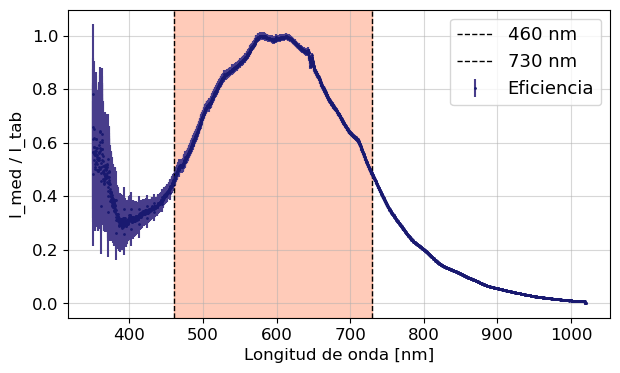

In [17]:
#plt.figure(dpi=300)
plt.errorbar(lambdas_med_filtrados, eficiencia, yerr= err_eficiencia, fmt = ".", color = "midnightblue" ,  ecolor = 'darkslateblue', markersize = 2, label = 'Eficiencia')
plt.axvspan(460, 730, color='coral', alpha=0.4)
plt.axvline(x=460, color='black', linestyle='--', linewidth=1, label="460 nm")
plt.axvline(x=730, color='black', linestyle='--', linewidth=1, label="730 nm")

plt.tick_params(axis='both', labelsize=12)
plt.xlabel('Longitud de onda [nm]', fontsize = 12)
plt.ylabel('I_med / I_tab', fontsize = 12)
plt.grid(alpha = 0.5)
plt.legend(fontsize = 13)
plt.show()